In [1]:
# before runing, please update "Notebook File Root" to ${workspaceFolder}
# to make sure the following import works
import hydra
import torch
import os
from ucc.dataset import CamelyonUCCDataset
from ucc.model import UCCModel
from omegaconf import DictConfig, OmegaConf
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from ucc.visualize import plot_confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

/opt/miniconda3/envs/torch1.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. setup and init
### 1.1 init config

In [2]:
with hydra.initialize(version_base=None, config_path="../configs"):
    cfg = hydra.compose(config_name="test.yaml", overrides=["experiment=camelyon"])
print(OmegaConf.to_yaml(cfg))

args:
  model_path: saved_models/camelyon_ucc_best.pth
  num_instances: 32
  ucc_start: 1
  ucc_end: 4
  batch_size: 16
  num_workers: 4
  num_bins: 11
  num_features: 10
  seed: 22
  dataset: camelyon
  model_name: camelyon_ucc
  patch_size: 32
  data_augment: true
  train_num_steps: 1000000
  val_num_steps: 46
model:
  kde_model:
    num_bins: 11
    sigma: 0.1
  patch_model:
    conv_input_channel: 3
    conv_output_channel: 16
    block1_output_channel: 32
    block1_num_layer: 1
    block2_output_channel: 64
    block2_num_layer: 1
    block3_output_channel: 128
    block3_num_layer: 1
    flatten_size: 8192
    num_features: 16
  image_generation_model:
    linear_size: 8192
    reshape_size:
    - 128
    - 8
    - 8
    block1_output_channel: 128
    block1_num_layer: 1
    block2_output_channel: 64
    block2_num_layer: 1
    block3_output_channel: 32
    block3_num_layer: 1
    output_channel: 3
  classification_model:
    fc1_output_size: 384
    fc2_output_size: 192
    dro

### 1.2 init model

In [3]:
def init_model(model_cfg, checkpoint_path, device):
    model = UCCModel(model_cfg)
    # load checkpoint
    ckpt = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    state_dict = ckpt["model_state_dict"]
    msg = model.load_state_dict(state_dict)
    print("load ckpt msg: ", msg)
    model.to(device)
    return model

In [4]:
model = init_model(cfg.model, cfg.args.model_path, device)
print(model)

load ckpt msg:  <All keys matched successfully>
UCCModel(
  (patch_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): WideResidualBlocks(
      (blocks): Sequential(
        (0): ResidualZeroPaddingBlock(
          (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (skip_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (2): WideResidualBlocks(
      (blocks): Sequential(
        (0): ResidualZeroPaddingBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (skip_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
        )
      )
    )
    (3): WideResidualBlocks(
      (blocks): Sequential(
        (0): ResidualZeroPaddingBlock(
          (conv1)

### 1.3 init dataloader

In [5]:
def init_dataloader(args):
    def dataloader(dataset, batch_size):
        for i in range(0, len(dataset)):
            batch_samples, batch_labels = [], []
            for _ in range(batch_size):
                sample, label = dataset[i]
                batch_samples.append(sample)
                batch_labels.append(label)
            yield torch.stack(batch_samples), torch.stack(batch_labels)

    test_dataset = CamelyonUCCDataset(
        mode="test", 
        num_instances=args.num_instances, 
        patch_size=args.patch_size,
        data_augment=False)
    # a dataloader repeat the same sample for batch_size times
    test_loader = dataloader(test_dataset, batch_size=100)
    return test_dataset, test_loader

In [6]:
test_dataset, test_loader = init_dataloader(cfg.args)
for i, (batch_samples, batch_labels) in enumerate(test_loader):
    batch_samples = batch_samples.to(device)
    batch_labels = batch_labels.to(device)
    print(batch_samples.shape, batch_labels.shape)
    print(batch_labels)
    if i > 5:
        break

torch.Size([100, 32, 3, 32, 32]) torch.Size([100])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='mps:0')
torch.Size([100, 32, 3, 32, 32]) torch.Size([100])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='mps:0')
torch.Size([100, 32, 3, 32, 32]) torch.Size([100])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## 2. Reproduce Experiment Results
### 2.1 bag level confusion matrix

In [7]:
# get batch predictions
all_probs, all_predicted, all_labels = [], [], []
for i, (batch_samples, batch_labels) in enumerate(test_loader):
    batch_samples = batch_samples.to(device)
    with torch.no_grad():
        batch_probs, _ = model(batch_samples)
    batch_probs = batch_probs.cpu().numpy()
    batch_predicted = np.argmax(batch_probs, axis=1)
    all_probs.append(batch_probs)
    all_predicted.append(batch_predicted)
    all_labels.append(batch_labels.cpu().numpy())

In [8]:
# temporary save all_probs, all_predicted, all_labels
all_probs = np.array(all_probs).reshape(-1, 100, 2)
all_predicted = np.array(all_predicted).reshape(-1, 100)
all_labels = np.array(all_labels).reshape(-1, 100)
print(all_probs.shape, all_predicted.shape, all_labels.shape)

np.savez("outputs/camelyon_ucc_test.npz", all_probs=all_probs, all_predicted=all_predicted, all_labels=all_labels)

(1171, 100, 2) (1171, 100) (1171, 100)


In [9]:
conf_mat = confusion_matrix(np.concatenate(all_labels), np.concatenate(all_predicted))
ucc_acc = np.sum(conf_mat.diagonal())/np.sum(conf_mat)
print("ucc_acc: ", ucc_acc)

ucc_acc:  0.8095900939368061


Normalized confusion matrix


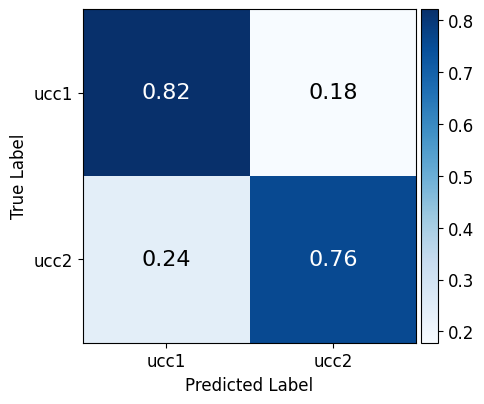

In [10]:
class_names = ['ucc1', 'ucc2']
fig1 = plt.figure(figsize=(5,5))
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True, title='Confusion matrix')

Confusion matrix, without normalization


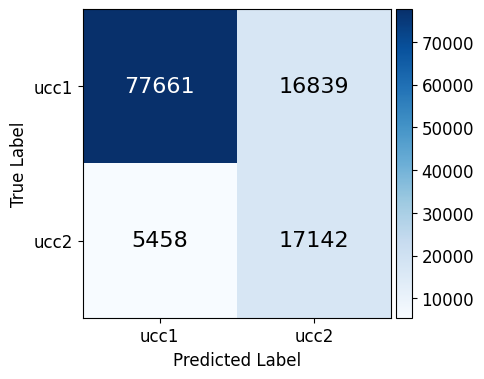

In [11]:
fig2 = plt.figure(figsize=(5,5))
plot_confusion_matrix(conf_mat, classes=class_names, normalize=False, title='Confusion matrix')

### 2.2 image level statistics

In [12]:
def get_patient_dict(prob_arr=None, truth_class = None):
    temp_patient_dict = dict()
    temp_patient_dict['mean_prob']=np.mean(prob_arr)
    temp_patient_dict['median_prob']=np.median(prob_arr)
    temp_patient_dict['std_prob']=np.std(prob_arr)
    temp_patient_dict['correct_pred_ratio']=np.sum(prob_arr>0.5)/len(prob_arr)
    temp_patient_dict['truth']=truth_class

    return temp_patient_dict

In [13]:
patient_metrics_dict = {}
for i, (prob, label) in enumerate(zip(all_probs, all_labels)):
    patient_metrics_dict[i] = get_patient_dict(prob[:, label[0]], label[0])

#### 2.2.1 cpr: correct prediction ratio

In [14]:
## cpr: correct prediction ratio, tcmp: truth class mean probability
patient_truth_list = list()
patient_predicted_cpr_list = list()
patient_predicted_tcmp_list = list()
for patient_id in patient_metrics_dict:
    truth = patient_metrics_dict[patient_id]['truth']
    cpr = patient_metrics_dict[patient_id]['correct_pred_ratio']
    tcmp = patient_metrics_dict[patient_id]['mean_prob']
    tcmdp = patient_metrics_dict[patient_id]['median_prob']
    tcstdp = patient_metrics_dict[patient_id]['std_prob']

    if cpr > 0.5:
        pred_cpr = truth
    else:
        pred_cpr = 1 - truth
    patient_predicted_cpr_list.append(pred_cpr)

    if tcmp > 0.5:
        pred_tcmp = truth
    else:
        pred_tcmp = 1 - truth
    patient_predicted_tcmp_list.append(pred_tcmp)
    patient_truth_list.append(truth)

In [15]:
cpr_conf_mat = confusion_matrix(
    np.array(patient_truth_list), 
    np.array(patient_predicted_cpr_list)
)
cpr_ucc_acc = np.sum(cpr_conf_mat.diagonal())/np.sum(cpr_conf_mat)
print("cpr ucc_acc: ", cpr_ucc_acc)

cpr ucc_acc:  0.8368915456874466


Normalized confusion matrix


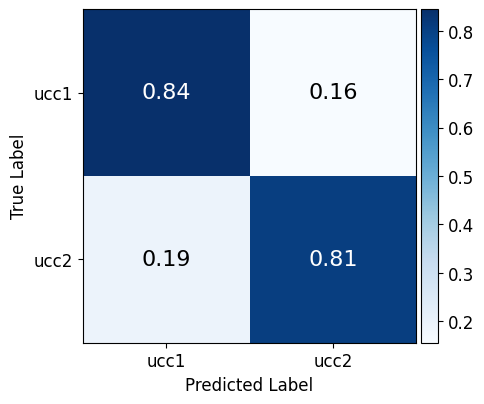

In [16]:
class_names = ['ucc1', 'ucc2']
fig = plt.figure(figsize=(5,5))
plot_confusion_matrix(cpr_conf_mat, classes=class_names, normalize=True, title='Confusion matrix')

Confusion matrix, without normalization


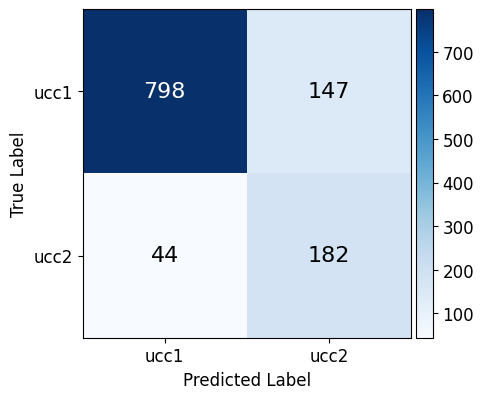

In [17]:
fig = plt.figure(figsize=(5,5))
plot_confusion_matrix(cpr_conf_mat, classes=class_names, normalize=False, title='Confusion matrix')

#### 2.2.2 tcmp: truth class mean probability

In [18]:
tcmp_conf_mat = confusion_matrix(
    np.array(patient_truth_list), 
    np.array(patient_predicted_tcmp_list)
)
tcmp_ucc_acc = np.sum(tcmp_conf_mat.diagonal())/np.sum(tcmp_conf_mat)
print("tcmp ucc_acc: ", tcmp_ucc_acc)

tcmp ucc_acc:  0.8334756618274979


Normalized confusion matrix


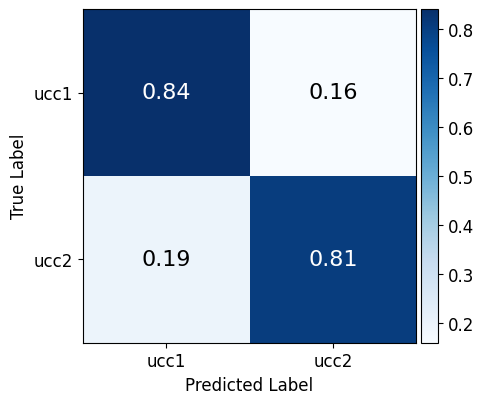

In [19]:
fig = plt.figure(figsize=(5,5))
plot_confusion_matrix(tcmp_conf_mat, classes=class_names, normalize=True, title='Confusion matrix')

Confusion matrix, without normalization


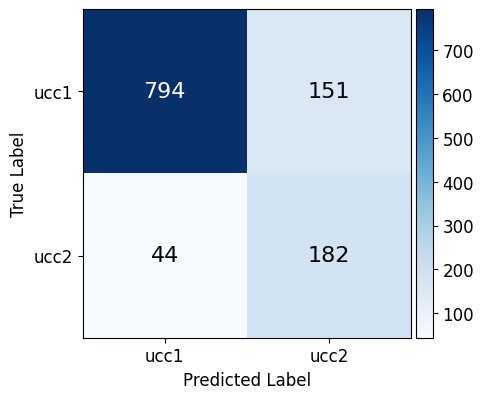

In [20]:
fig = plt.figure(figsize=(5,5))
plot_confusion_matrix(tcmp_conf_mat, classes=class_names, normalize=False, title='Confusion matrix')

### 2.3 extract patch features

In [21]:
extracted_features_list = []
patch_labels_list = []
for i in range(len(test_dataset)):
	patches = test_dataset.get_image_patches(i).to(device)
	patch_labels = test_dataset.get_image_patch_labels(i)
	with torch.no_grad():
		features = model.patch_model(patches)
		features = features.cpu().numpy()
	extracted_features_list.append(features)
	patch_labels_list.append(patch_labels)
# temporary save extracted_features_list and patch labels
extracted_features_np = np.array(extracted_features_list)
np.save("outputs/camelyon_patch_features.npy", extracted_features_np)
patch_labels_np = np.array(patch_labels_list)
print(extracted_features_np.shape, patch_labels_np.shape)
np.save("outputs/camelyon_patch_labels.npy", patch_labels_np)

(1178, 256, 16) (1178, 256)


### 2.4 clustering patches

In [22]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans, SpectralClustering
from prettytable import PrettyTable
from scipy.optimize import linear_sum_assignment

In [23]:
def cluster(estimator=None, name=None, data=None, labels=None):
	t0 = time()
	estimator.fit(data)
	homogeneity_score = metrics.homogeneity_score(labels, estimator.labels_)
	completeness_score = metrics.completeness_score(labels, estimator.labels_)
	v_measure_score = metrics.v_measure_score(labels, estimator.labels_)
	adjusted_rand_score = metrics.adjusted_rand_score(labels, estimator.labels_)
	adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(labels,  estimator.labels_)

	table = PrettyTable()
	table.field_names = ["init", "time", "homo", "compl", "v-meas", "ARI", "AMI"]
	table.add_row([name, round((time() - t0), 2), 
		round(homogeneity_score, 3), 
		round(completeness_score, 3), 
		round(v_measure_score, 3), 
		round(adjusted_rand_score, 3), 
		round(adjusted_mutual_info_score, 3)])
	print(table)

	clustering_scores = np.array([homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score]).reshape((1,-1))
	return clustering_scores, estimator.labels_

#### 2.4.1 eval clustering by metrics

In [24]:
# cluster all data
num_samples, num_patches, num_features = extracted_features_np.shape
num_clusters = 2
extracted_features_2d = extracted_features_np.reshape((-1, num_features))
patch_labels_1d = patch_labels_np.reshape(-1)
print(patch_labels_1d.shape, extracted_features_2d.shape)
# estimator = SpectralClustering(n_clusters=num_clusters, eigen_solver='arpack', affinity="nearest_neighbors")
# nn_clustering_scores, nn_predicted_labels_arr = cluster(estimator=estimator, name='all: kmeans++', data=extracted_features_2d, labels=patch_labels_1d)

estimator = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10)
kmeans_clustering_scores, kmeans_predicted_labels_arr = cluster(estimator=estimator, name='all: kmeans++', data=extracted_features_2d, labels=patch_labels_1d)

(301568,) (301568, 16)
+---------------+------+-------+-------+--------+-------+-------+
|      init     | time |  homo | compl | v-meas |  ARI  |  AMI  |
+---------------+------+-------+-------+--------+-------+-------+
| all: kmeans++ | 1.46 | 0.311 | 0.288 | 0.299  | 0.299 | 0.299 |
+---------------+------+-------+-------+--------+-------+-------+


#### 2.4.2 calculate clustering accuracy

In [25]:
def compute_clustering_accuracy(truth_labels_arr, predicted_labels_arr):	
    cost_matrix = np.zeros((2,2))
    num_samples = np.zeros(2)
    for truth_val in range(2):
        temp_sample_indices = np.where(truth_labels_arr == truth_val)[0]
        num_samples[truth_val] = temp_sample_indices.shape[0]

        temp_predicted_labels = predicted_labels_arr[temp_sample_indices]

        for predicted_val in range(2):

            temp_matching_pairs = np.where(temp_predicted_labels == predicted_val)[0]

            cost_matrix[truth_val,predicted_val] = 1- (temp_matching_pairs.shape[0]/temp_sample_indices.shape[0])

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    cost = cost_matrix[row_ind,col_ind]

    clustering_acc = ((1-cost)*num_samples).sum() / num_samples.sum()

    return cost, row_ind, col_ind, clustering_acc

In [26]:
cost, row_ind, col_ind, kmeans_cluster_acc = compute_clustering_accuracy(
    patch_labels_1d, kmeans_predicted_labels_arr)
print('kmeans_cluster_acc: {:.3f}'.format(kmeans_cluster_acc))
if row_ind[0] != col_ind[0]:
    kmeans_predicted_labels_arr = 1 - kmeans_predicted_labels_arr 
print(metrics.accuracy_score(patch_labels_1d, kmeans_predicted_labels_arr))

kmeans_cluster_acc: 0.773
0.773470660016978


Normalized confusion matrix


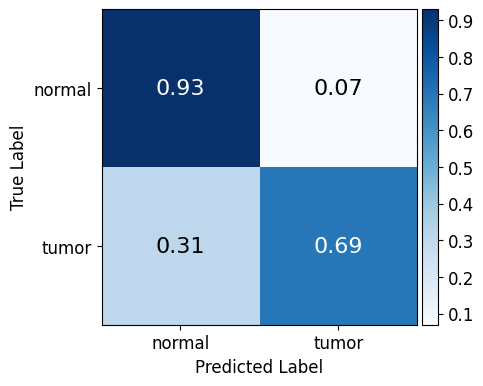

In [27]:
conf_mat = confusion_matrix(patch_labels_1d, kmeans_predicted_labels_arr)
class_names = ['normal', 'tumor']
fig = plt.figure(figsize=(5,5))
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True, title='Confusion matrix')

In [1]:
fig = plt.figure(figsize=(5,5))
plot_confusion_matrix(conf_mat, classes=class_names, normalize=False, title='Confusion matrix')

NameError: name 'plt' is not defined

### 2.5 create predicted masks
#### 2.5.1 plot predicted masks

In [29]:
color_code_dict = {	'00':np.array([0,0,255]),
					'01':np.array([255,0,0]),
					'10':np.array([255,255,0]),
					'11':np.array([0,255,0])}
stride = int(num_patches**0.5)
patch_labels_binary_mask = patch_labels_1d.reshape(
	(num_samples, stride, stride))
kmeans_predicted_binary_mask = kmeans_predicted_labels_arr.reshape(
    (num_samples, stride, stride))

Text(0.5, 1.0, 'Kmeans Predicted')

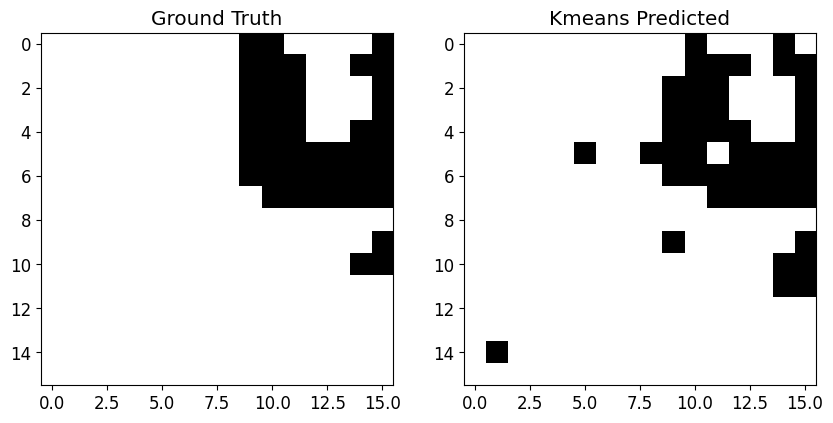

In [30]:
# plot the ground truth and predict with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(patch_labels_binary_mask[0], cmap='gray')
axes[0].set_title('Ground Truth')
axes[1].imshow(kmeans_predicted_binary_mask[0], cmap='gray')
axes[1].set_title('Kmeans Predicted')

In [31]:
# merge the ground truth and predict with color dict
kmeans_predicted_color_mask = np.zeros((num_samples, stride, stride, 3))
for i in range(num_samples):
    for j in range(stride):
        for k in range(stride):
            patch_gt = patch_labels_binary_mask[i,j,k]
            patch_predicted_label = kmeans_predicted_binary_mask[i,j,k]
            kmeans_predicted_color_mask[i,j,k] = color_code_dict[str(int(patch_gt))+str(int(patch_predicted_label))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


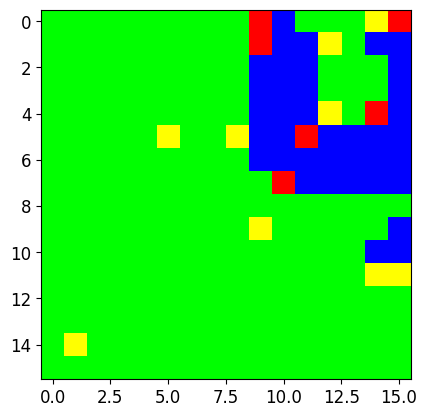

In [32]:
# plot color mask
fig2 = plt.figure()
plt.imshow(kmeans_predicted_color_mask[0])

#### 2.5.2 calculate metrics

In [33]:
# calculate the TP, FP, TN, FN, pixel_acc of each patch
TP = np.zeros(num_samples)
FP = np.zeros(num_samples)
TN = np.zeros(num_samples)
FN = np.zeros(num_samples)
pixel_acc = np.zeros(num_samples)
for i in range(num_samples):
    TP[i] = np.sum(np.logical_and(
        patch_labels_binary_mask[i], kmeans_predicted_binary_mask[i]))
    FP[i] = np.sum(np.logical_and(
        np.logical_not(patch_labels_binary_mask[i]), kmeans_predicted_binary_mask[i]))
    TN[i] = np.sum(np.logical_and(
        np.logical_not(patch_labels_binary_mask[i]), np.logical_not(kmeans_predicted_binary_mask[i])))
    FN[i] = np.sum(np.logical_and(
        patch_labels_binary_mask[i], np.logical_not(kmeans_predicted_binary_mask[i])))
    pixel_acc[i] = (TP[i] + TN[i]) / (TP[i] + FP[i] + TN[i] + FN[i])
# calculate the mean of TP, FP, TN, FN, pixel_acc
TP_mean = np.mean(TP)
FP_mean = np.mean(FP)
TN_mean = np.mean(TN)
FN_mean = np.mean(FN)
pixel_acc_mean = np.mean(pixel_acc)
print('TP_mean: {:.3f}'.format(TP_mean))
print('FP_mean: {:.3f}'.format(FP_mean))
print('TN_mean: {:.3f}'.format(TN_mean))
print('FN_mean: {:.3f}'.format(FN_mean))
print('pixel_acc_mean: {:.3f}'.format(pixel_acc_mean))

TP_mean: 116.765
FP_mean: 6.081
TN_mean: 81.244
FN_mean: 51.910
pixel_acc_mean: 0.773


#### 2.5.3 postprocess

In [34]:
import cv2

In [35]:
# use cv2.medianBlur to post-process the predicted mask
kmeans_predicted_binary_mask_blur = np.zeros((num_samples, stride, stride))
for i in range(num_samples):
    kmeans_predicted_binary_mask_blur[i] = (cv2.medianBlur(
        255 * kmeans_predicted_binary_mask[i].astype(np.uint8), 129) > 128)

In [36]:
# calculate the TP, FP, TN, FN, pixel_acc of each blurred patch
TP_blur = np.zeros(num_samples)
FP_blur = np.zeros(num_samples)
TN_blur = np.zeros(num_samples)
FN_blur = np.zeros(num_samples)
pixel_acc_blur = np.zeros(num_samples)
for i in range(num_samples):
    TP_blur[i] = np.sum(np.logical_and(
        patch_labels_binary_mask[i], kmeans_predicted_binary_mask_blur[i]))
    FP_blur[i] = np.sum(np.logical_and(
        np.logical_not(patch_labels_binary_mask[i]), kmeans_predicted_binary_mask_blur[i]))
    TN_blur[i] = np.sum(np.logical_and(
        np.logical_not(patch_labels_binary_mask[i]), np.logical_not(kmeans_predicted_binary_mask_blur[i])))
    FN_blur[i] = np.sum(np.logical_and(
        patch_labels_binary_mask[i], np.logical_not(kmeans_predicted_binary_mask_blur[i])))
    pixel_acc_blur[i] = (TP_blur[i] + TN_blur[i]) / \
        (TP_blur[i] + FP_blur[i] + TN_blur[i] + FN_blur[i])
# calculate the mean of TP, FP, TN, FN, pixel_acc
TP_blur_mean = np.mean(TP_blur)
FP_blur_mean = np.mean(FP_blur)
TN_blur_mean = np.mean(TN_blur)
FN_blur_mean = np.mean(FN_blur)
pixel_acc_blur_mean = np.mean(pixel_acc_blur)
print('TP_blur_mean: {:.3f}'.format(TP_blur_mean))
print('FP_blur_mean: {:.3f}'.format(FP_blur_mean))
print('TN_blur_mean: {:.3f}'.format(TN_blur_mean))
print('FN_blur_mean: {:.3f}'.format(FN_blur_mean))
print('pixel_acc_blur_mean: {:.3f}'.format(pixel_acc_blur_mean))

TP_blur_mean: 122.110
FP_blur_mean: 6.317
TN_blur_mean: 81.008
FN_blur_mean: 46.565
pixel_acc_blur_mean: 0.793
